In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

# Performance profiling
NxSDK offers performance profiling while executing a spiking neuron network and/or snips on one of the embedded CPUs. This allows to measure both execution time and power/energy consumption by Loihi in real-time. In order to support both, NxSDK provides ExecutionTime and EnergyProbes which are analogous to other state probes for membrane potential, spikes, etc. 

EnergyProbes allow to measure both energy and execution time while ExecutionTimeProbes allow to only measure execution time. Energy is measured by the host CPU while the execution time is measured by one of the embedded Lakemont (LMT) CPUs which drives the time step advancement. Both energy and execution time series are acquired independently and asynchronously from each other. This means that the host acquires the power as a function of the host time $P(t_H)$ while the embedded CPU acquires the wall clock time as a function of algorithmic time step $t_{LMT}(t)$ or $t(t_{LMT})$. Hence the time stamps $t_H$ and $t_{LMT}$ of the respective data points are different. Only at the end of a network execution are $t_H$ and $t_{LMT}$ synchronized and the wall clock time at the beginning of the execution is subtracted from both of them to reference the data points with respect to the beginning of the network execution. In addition, the power readings $P(t_H)$ are interpolated onto the set of time points $t_{LMT}$: $P(t_H) \rightarrow P(t_{LMT})$. As a result, both power and execution time are available as a function of algorithmic time steps: $P(t_{LMT}) \leftrightarrow P(t), t_{LMT}(t)$.

During each algorithmic time step, the embedded CPUs and neuro cores go through a number of different sequential but optional phases:
1. Spiking: During the first phase, neuro cores update their internal state and send and receive spike messages amongst them or the environment. No other message types than spike messages are allowed in the asynchronous mesh during this phase. In addition, the user has the possibility to execute a snip during the 'spiking' phase.
2. Pre-Learning Management: If the 'learning' phase is executed during the current time step, the user has the option to execute an optional 'Pre-Learning management' phase just before the 'learning' phase. During a 'Pre-Learning management' phase, the neuro cores enter a mode during which they are able to process management messages via the asynchrnous mesh while the user has the option to execute another snip during the 'Pre-Learning management' phase.
3. Learning: Every multiple of a predefined learning epoch, the neuro cores update their synaptic state. During this phase, no spike or management message will be processed by the neuro cores.
4. Management: Independent of whether a 'learning' phase is executed during the current time step or not, another 'management' phase can be executed at the end or just after the 'learning' phase giving the user another possibility to execute a snip. After this 'management' phase, the embedded CPU will immediately proceed to the next algorithmic time step or will hand control back to the host CPU. In case the host takes over, it may either reconfigure the system or probe any of the states within the neuro cores or the spike counters in the embedded CPUs.
During each algorithmic time step, one of the embedded CPUs measures the time at the start ($t_{LMT}^S[i]$) and end ($t_{LMT}^E[i]$) of an algorithmic time step i just after the last optional 'management' phase. We call the time  $t_{LMT}^S[i+1]-t_{LMT}^E[i]$ the 'host' time during which the host may interact with the system. 

Because the sensor used to measure power consumption has a rather long time constant on the order of miliseconds, workloads should generally be repeated multiple times in order to allow the system to settle into a steady state for reliable energy characterizations.
It should also be noted that probing of neuro core states at the end of an algorithmic time step slows down execution drastically. Hence probing should also be avoided to meaningfully characterize neuro core performance in isolation.

In this tutorial, we first define a couple of helper functions to set up a dummy neural network and functions to plot the results conveniently. Then we exercise EnergyProbes (which include ExecutionTimeProbes) in various scenarios subject to different workloads.

In [3]:
import os, math
import matplotlib.pyplot as plt
import numpy as np

from nxsdk.arch.n2a.n2board import N2Board
from nxsdk.api.enums.api_enums import ProbeParameter
from nxsdk.graph.monitor.probes import PerformanceProbeCondition

## 1. SLURM partition selection
Choose a persistent SLURM parition/board for performance profiling to execute on same board for consistent results.

__Internal vlab:__

In [4]:
os.environ['PARTITION'] = "nahuku32"
os.environ['BOARD'] = "ncl-ghrd-01"

__External vlab:__

In [5]:
#os.environ['PARTITION'] = "nahuku08"
#os.environ['BOARD'] = "ncl-ext-ghrd-03"

## 2. Creating a minimal network with execution time and energy probes
Both execution time probes and energy probes are generated via the N2Board object. Since the energy probe also requires the measurement of execution time it is actually a subclass of the execution time probe class and shares some of its interface.
Thus if an energy probe is created a separate exeuction time probe is not required.

In [6]:
# Creating an execution time probe
board = N2Board(id=0, numChips=1, numCores=[1], initNumSynapses=[[1]])

etProbe = board.probe(
    probeType=ProbeParameter.EXECUTION_TIME, 
    probeCondition=PerformanceProbeCondition(
        tStart=1, 
        tEnd=100000, 
        bufferSize=1024, 
        binSize=2)
)

# Creating an execution time probe
board = N2Board(id=0, numChips=1, numCores=[1], initNumSynapses=[[1]])

eProbe = board.probe(
    probeType=ProbeParameter.ENERGY, 
    probeCondition=PerformanceProbeCondition(
        tStart=1, 
        tEnd=100000, 
        bufferSize=1024, 
        binSize=2)
)

board.run(100000)
board.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:HST:  srun: job 2522113 queued and waiting for resources
INFO:HST:  srun: job 2522113 has been allocated resources
INFO:DRV:  Connecting to 134.134.68.92:46753
INFO:DRV:      Host server up..............Done 9.47s
INFO:DRV:      Compiling Embedded snips....Done 0.15s
INFO:DRV:      Encoding axons/synapses.....Done 0.84ms
INFO:HST:  Config /etc/nx/pio.cfg
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1590103439.5695903/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 7.86s
INFO:DRV:      Encoding probes.............Done 0.53ms
INFO:DRV:      Transferring probes.........Done 8.44ms
INFO:DRV:      Configuring registers.......Done 2.50ms
INFO:DRV:      Transferring spikes.........Done 0.48ms
INFO:DRV:      Executing...................Done 1.94s
INFO:DRV:      Processing timeseries.......Done 0.18s
INFO:DRV:  Executo

## 3. Sample workload
runNetwork(..) defines a scaleable dummy workload that is used throughout this tutorial to stress the HW system with networks of different sizes. 

The network is not constructed to perform a meaningful computation but rather to produce a well defined activity pattern.
- There are numCoresPerChip and numCompartmentsPerCore. The connectivity per compartment is configuarble by numAxonsPerCompartment and numSynPerAxon. The compartments in each neuro core only connect back to the same neuro core for simplicity.
- Each neuron integrates a bias current at produces spikes at a regular interSpikeInterval for a certain runtime.
- The bufferSize control the size of the ExecutionTimeProbe buffer on the embedded CPU which will compete with snips for Lakemont memory in a general setting. The binSize determines how many execution times of consecutive time steps get averaged into the same time bin of the the execution time buffer.

The network is configured at the NxCore API level for the sole reason of having full control over how this network is distributed over neuro cores. Other than the high level explanation and parameterization above the specific implementation of the network is irrelevant for this tutorial.

In [7]:
def runNetwork(numCoresPerChip=1, numCompartmentsPerCore=1, 
               numAxonsPerCompartment=1, numSynPerAxon=1, 
               interSpikeInterval=1, runtime=1,
               bufferSize=1024, binSize=1,
               tEpoch=0,
               createDebugProbe=False):
    """Creates a scalable sample network, executes the network and returns energy, voltaga and spike probes."""
    
    assert numCompartmentsPerCore*numAxonsPerCompartment <= 4096
    
    board = N2Board(id=0,
                    numChips=1,
                    numCores=[numCoresPerChip],
                    initNumSynapses=[[numCompartmentsPerCore*numSynPerAxon]*numCoresPerChip])
    
    vth = 1000
    bias = int(vth//interSpikeInterval)
    
    # Configure compartments on cores
    for core in board.n2Chips[0].n2CoresAsList:
        core.numUpdates.configure(numUpdates=math.ceil(numCompartmentsPerCore/4))
        core.cxProfileCfg[0].configure(
            decayV=0,
            bapAction=0,
            refractDelay=1)
        core.vthProfileCfg[0].staticCfg.configure(vth=vth)
        core.dendriteAccumCfg[0].configure(delayBits=3)
        for i in range(numCompartmentsPerCore):
            core.cxCfg[i].configure(
                bias=bias,
                biasExp=6)
            core.cxMetaState[i//4].configure(phase0=2, phase1=2, phase2=2, phase3=2)
        
    # Connect compartments on cores
    for core in board.n2Chips[0].n2CoresAsList:
        ptr = 0
        for i in range(numCompartmentsPerCore):
            # Create output axon
            core.createDiscreteAxon(
                srcCxId=i,
                dstChipId=0,
                dstCoreId=core.id,
                dstSynMapId=i*2**(tEpoch>0))
            
            # Create input axon
            synMapId = i*2**(tEpoch>0)
            core.synapseMap[synMapId].synapsePtr=ptr
            core.synapseMap[synMapId].synapseLen=numSynPerAxon
            core.synapseMap[synMapId].discreteMapEntry.configure()
            ptr+=numSynPerAxon
            
            # Create synapses
            for k, j in enumerate(range(i*numSynPerAxon, (i+1)*numSynPerAxon)):
                core.synapses[j].configure(CIdx=k, Wgt=0, LrnEn=1, synFmtId=1)
    
        # Create synapse formats
        core.synapseFmt[1].configure(numSynapses=63, idxBits=5, wgtBits=1, compression=3, fanoutType=2, learningCfg=3)
        
        # Enable learning
        if tEpoch>0:
            core.stdpPreProfileCfg[0].configure(updateAlways=1)
            core.stdpCfg[0].configure(firstLearningIndex = 0)
            core.numUpdates[0].configure(numStdp=numAxonsPerCompartment)
            core.timeState[0].configure(tepoch=tEpoch)
        
    vProbe = sProbe = None
    if createDebugProbe:
        vProbe = board.monitor.probe(board.n2Chips[0].n2Cores[0].cxState, [0], 'v')[0]
        sProbe = board.monitor.probe(board.n2Chips[0].n2Cores[0].cxState, [0], 'spike')[0]
        
    # Create energy probe
    pc = PerformanceProbeCondition(tStart=1, tEnd=runtime, bufferSize=bufferSize, binSize=binSize)
    eProbe = board.probe(ProbeParameter.ENERGY, pc)
    
    # Run network
    board.run(runtime)
    board.disconnect()
    
    powerStats = board.energyTimeMonitor.powerProfileStats
    
    return eProbe, vProbe, sProbe, powerStats

## 4. Basics of probing and execution time

### 4.1 Activity of a single neuron
Below we demonstrate the operation of the dummy network by observing the membrane voltage and output spikes of a single neuron in the network whose dynamics is repeated multiple times across a chip.

In [8]:
eProbe, vProbe, sProbe, _ = runNetwork(
    numCoresPerChip=1, 
    numCompartmentsPerCore=1, 
    numAxonsPerCompartment=1, 
    numSynPerAxon=1, 
    interSpikeInterval=10, 
    runtime=1000,
    bufferSize=1024,
    createDebugProbe=True
)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.92:35757
INFO:DRV:      Host server up..............Done 0.17s
INFO:DRV:      Compiling Embedded snips....Done 0.11s
INFO:DRV:      Encoding axons/synapses.....Done 2.10ms
INFO:HST:  Config /etc/nx/pio.cfg
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1590103451.485287/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 7.85s
INFO:DRV:      Encoding probes.............Done 0.62ms
INFO:DRV:      Transferring probes.........Done 7.68ms
INFO:DRV:      Configuring registers.......Done 3.19ms
INFO:DRV:      Transferring spikes.........Done 0.53ms
INFO:DRV:      Executing...................Done 0.40s
INFO:DRV:      Processing timeseries.......Done 0.11s
INFO:DRV:  Executor: 1000 timesteps........Done 8.67s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


Text(0.5,0,'Time step')

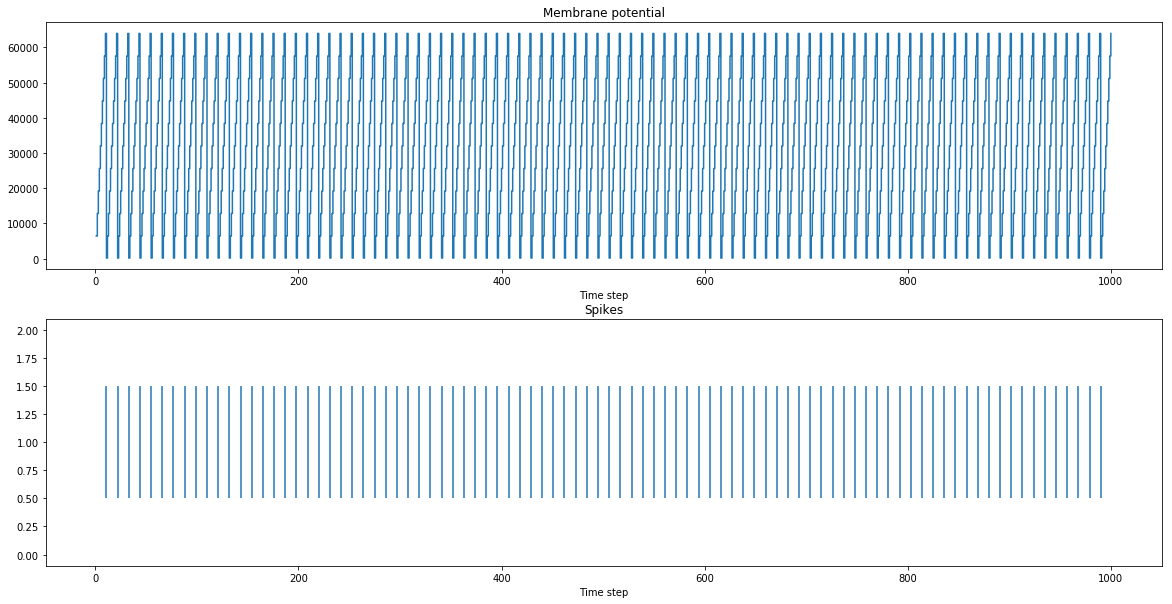

In [9]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1)
vProbe.plot()
plt.title('Membrane potential')

plt.subplot(2, 1, 2)
sProbe.plot()
plt.gca().set_xlim(ax.get_xlim())
plt.title('Spikes')
plt.xlabel('Time step')

Each neuron integrates its bias current and spikes after 10 time steps.

### 4.2 Execution times
To illustrate execution time measurement, we first disable debug probes and execute the network without spiking activity but with synaptic plasticity enabled.

Note: No actual learning rule is configured in this sample workload. We only enable learning to see the effect on the various phases within a time step.

In [10]:
eProbeWithProbes, _, _, _ = runNetwork(
    numCoresPerChip=1, 
    numCompartmentsPerCore=1024, 
    numAxonsPerCompartment=1, 
    numSynPerAxon=256, 
    interSpikeInterval=1000, 
    runtime=1000,
    bufferSize=1024,
    tEpoch=16,
    createDebugProbe=False
)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.92:38353
INFO:DRV:      Host server up..............Done 0.16s
INFO:DRV:      Encoding axons/synapses.....Done 0.19s
INFO:DRV:      Compiling Embedded snips....Done 0.15s
INFO:HST:  Config /etc/nx/pio.cfg
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1590103463.4606912/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 7.85s
INFO:DRV:      Encoding probes.............Done 0.83ms
INFO:DRV:      Transferring probes.........Done 9.08ms
INFO:DRV:      Configuring registers.......Done 0.07s
INFO:DRV:      Transferring spikes.........Done 0.69ms
INFO:DRV:      Executing...................Done 0.05s
INFO:DRV:      Processing timeseries.......Done 6.64ms
INFO:DRV:  Executor: 1000 timesteps........Done 8.51s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


/home/gorchard/pyenv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gorchard/pyenv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


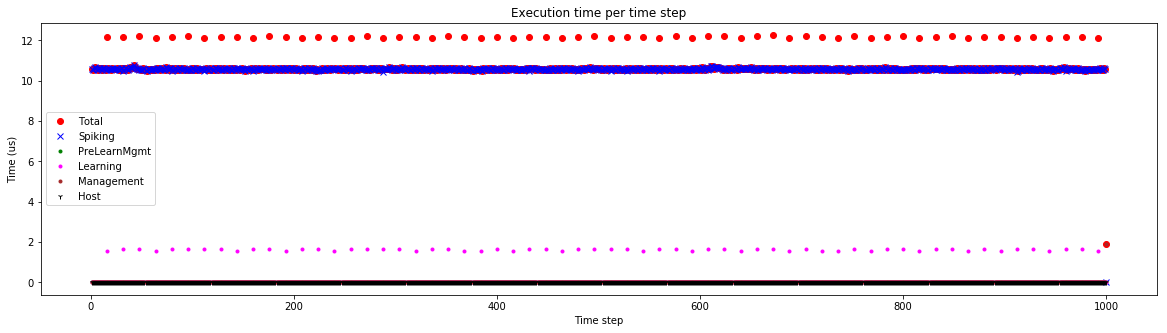

In [11]:
plt.figure(figsize=(20, 5))
eProbeWithProbes.plotExecutionTime()

The diagram shows the execution times per time step of the various sequential phases within a time step of which only the spiking phase is mandatory:
- Spiking: Duration of spiking phase
- (Optional) PreLearnMgmt: Duration of optional management phase before learning phase (here disabled)
- (Optional) Learning: Duration of learning phase. Since the learning epoch is set to 16, learning rules are executed every 16 time steps (although no actual learning rule is configured in this example).
- (Optional) Management: Duration of management at the end of each time step (here disabled)
- Host: Duration of host phase when the embedded Lakemont CPU returns control back to the host (here disabled)

During the 100 time steps of the experiment, the Lakemont CPU controls time step advancement without any interaction from the host.

### 4.3 Probing state impacts execution time
When we turn on debug probes to read out membrane potentials or other states, the embedded Lakemont CPU periodically returns control to the host, which in turn evaluates all probes. However this increase in system observability comes at the cost of additional execution time.

Note: ProbeConditions allow to specify an initial time offset as well as a probe interval which determines how often probes get evaluated.

In [12]:
eProbeWithoutProbes, _, _, _ = runNetwork(
    numCoresPerChip=1, 
    numCompartmentsPerCore=1, 
    numAxonsPerCompartment=1, 
    numSynPerAxon=1, 
    interSpikeInterval=10, 
    runtime=1000,
    bufferSize=1024,
    createDebugProbe=False
)
eProbeWithProbes, _, _, _ = runNetwork(
    numCoresPerChip=1, 
    numCompartmentsPerCore=1, 
    numAxonsPerCompartment=1, 
    numSynPerAxon=1, 
    interSpikeInterval=10, 
    runtime=1000,
    bufferSize=1024,
    createDebugProbe=True
)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.92:37227
INFO:DRV:      Host server up..............Done 0.16s
INFO:DRV:      Compiling Embedded snips....Done 0.11s
INFO:DRV:      Encoding axons/synapses.....Done 1.53ms
INFO:HST:  Config /etc/nx/pio.cfg
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1590103473.7208602/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 7.85s
INFO:DRV:      Encoding probes.............Done 0.74ms
INFO:DRV:      Transferring probes.........Done 8.07ms
INFO:DRV:      Configuring registers.......Done 4.66ms
INFO:DRV:      Transferring spikes.........Done 0.70ms
INFO:DRV:      Executing...................Done 0.04s
INFO:DRV:      Processing timeseries.......Done 5.77ms
INFO:DRV:  Executor: 1000 timesteps........Done 8.19s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in backgro

/home/gorchard/pyenv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gorchard/pyenv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


INFO:HST:  srun: job 2522119 has been allocated resources
INFO:DRV:  Connecting to 134.134.68.92:45881
INFO:DRV:      Host server up..............Done 19.20s
INFO:DRV:      Encoding axons/synapses.....Done 3.17ms
INFO:DRV:      Compiling Embedded snips....Done 0.16s
INFO:HST:  Config /etc/nx/pio.cfg
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1590103502.4961944/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 7.85s
INFO:DRV:      Encoding probes.............Done 0.68ms
INFO:DRV:      Transferring probes.........Done 8.20ms
INFO:DRV:      Configuring registers.......Done 3.05ms
INFO:DRV:      Transferring spikes.........Done 0.58ms
INFO:DRV:      Executing...................Done 0.41s
INFO:DRV:      Processing timeseries.......Done 0.11s
INFO:DRV:  Executor: 1000 timesteps........Done 27.76s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


Text(0.5,1,'Execution times with state probes')

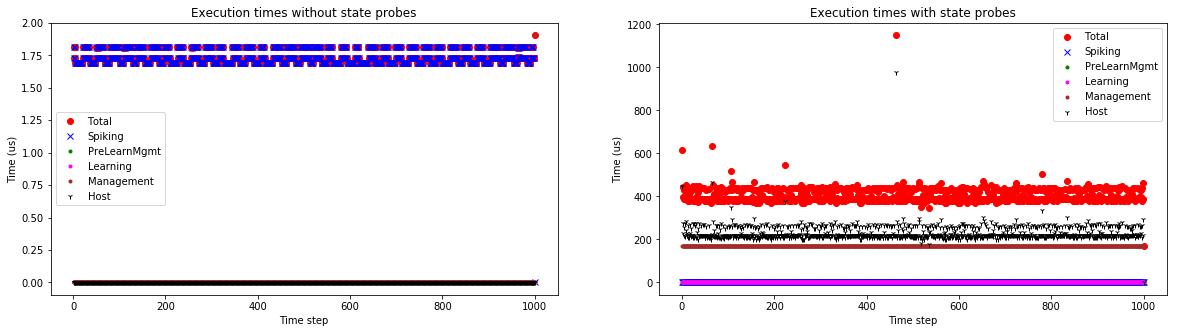

In [13]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
eProbeWithoutProbes.plotExecutionTime()
plt.title('Execution times without state probes')
plt.subplot(1, 2, 2)
eProbeWithProbes.plotExecutionTime()
plt.title('Execution times with state probes')

Without state probes, the host phase duration is zero. However, with state probes, the total execution time per time step increases because of the additional host phase time. During the host phase, the Lakemont returns control back to the host, which evaluates all registered probes, reads state from neuro registers and finally returns control back to Lakemont.

## 5. Power and Energy Profiling

## 5.1 Total Power Measurement
When power probes are used, raw power measurements taken during a run are returned to the user and can be plotted as shown below.

In [14]:
maxBufferSize = 1024*3
binSize = 64
runtime = maxBufferSize*binSize
eProbe, _, _, _ = runNetwork(
    numCoresPerChip=1, 
    numCompartmentsPerCore=0, 
    numAxonsPerCompartment=0, 
    numSynPerAxon=0, 
    interSpikeInterval=runtime*2, 
    runtime=runtime,
    bufferSize=maxBufferSize, 
    binSize=binSize
)

INFO:DRV:  SLURM is being run in background
INFO:HST:  srun: job 2522121 queued and waiting for resources
INFO:HST:  srun: job 2522121 has been allocated resources
INFO:DRV:  Connecting to 134.134.68.92:35575
INFO:DRV:      Host server up..............Done 17.69s
INFO:DRV:      Encoding axons/synapses.....Done 1.33ms
INFO:DRV:      Compiling Embedded snips....Done 0.11s
INFO:HST:  Config /etc/nx/pio.cfg
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1590103531.0100176/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 7.84s
INFO:DRV:      Encoding probes.............Done 0.57ms
INFO:DRV:      Transferring probes.........Done 7.82ms
INFO:DRV:      Configuring registers.......Done 2.66ms
INFO:DRV:      Transferring spikes.........Done 0.52ms
INFO:DRV:      Executing...................Done 0.44s
INFO:DRV:      Processing timeseries.......Done 0.04s
INFO:DRV:  Execut

Average VDD power: 840mW
Average VDDM power: 305mW


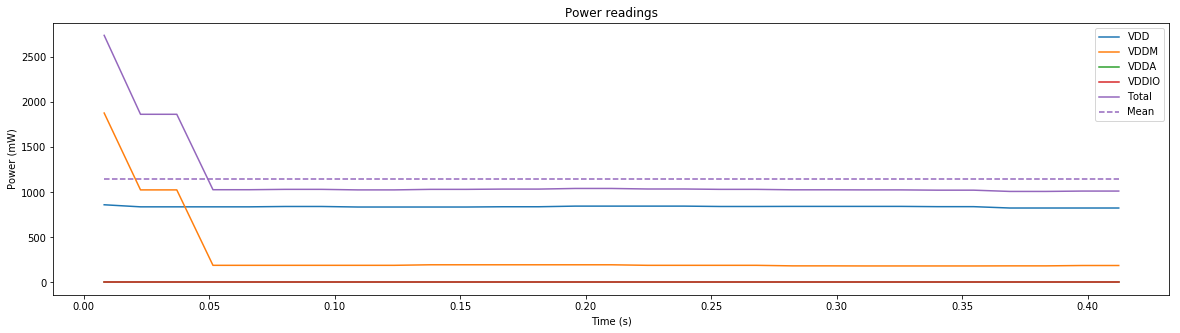

In [15]:
plt.figure(figsize=(20, 5))
eProbe.plotPower()
#plt.ylim(400, 800)
avgVddPower = np.mean(eProbe.rawPowerVdd)
avgVddmPower = np.mean(eProbe.rawPowerVddm)
print("Average VDD power: %dmW" % (avgVddPower))
print("Average VDDM power: %dmW" % (avgVddmPower))

The above diagram shows the raw power readings as a function of wall clock time througout network execution.

Each board supports to read out a number of different power components:
- VDD: Mostly compute logic
- VDDM: Mostly SRAMs
- VDDA: Mostly LMT clock generation
- VDDIO: Mostly FPIO/PIO interfaces

The power consumed by the system is recorded at the host level; independent from the embedded Lakemont CPUs. The power shown above is thus referenced against the time measured by the host. Only in the end are the two independent clocks of the Lakemont and host synchronized to determine the power or energy consumed in a particular time step. 

Without any workloads executing on neuro cores, we find idle/background power levels of around VDD=3100mW and VDDM=5400mW for Nahuku32 and VDD=40mV, VDDM=70mW, VDDIO=5mW for Wolf Mountain. These power levels are mostly due to leakage in the system.
Note: Nahuku can't measure the the contributions for VDDIO and VDDA separately.

### 5.2 Power profile of fully utilized Loihi chip
While the system is active, it consumes power that is dependent on the level of activity within the neuro cores. 
In this second power measurement, we chose certain parameters for bufferSize and binSize. Their specific impact on execution will be discussed below.
- The network has 128 active cores with 1024 neurons each to cause a significant enough workload. 
- The execution time buffer is set to roughly its maximum value that is still supported by the embedded Lakemont CPU memory.
- The execution time buffer bin size is set to 4, so the phase durations of 4 consecutive time steps are averaged.
- Spiking is disabled by setting the inter spike interval to twice the runtime.

In [16]:
maxBufferSize = 1024*3
binSize = 4
runtime = maxBufferSize*binSize
eProbe, _, _, _ = runNetwork(
    numCoresPerChip=128, 
    numCompartmentsPerCore=1024, 
    numAxonsPerCompartment=1, 
    numSynPerAxon=1, 
    interSpikeInterval=runtime*2, 
    runtime=runtime,
    bufferSize=maxBufferSize, 
    binSize=binSize
)

INFO:DRV:  SLURM is being run in background
INFO:HST:  srun: job 2522124 queued and waiting for resources
INFO:HST:  srun: job 2522124 has been allocated resources
INFO:DRV:  Connecting to 134.134.68.92:43391
INFO:DRV:      Host server up..............Done 14.07s
INFO:DRV:      Compiling Embedded snips....Done 0.16s
INFO:DRV:      Encoding axons/synapses.....Done 7.23s
INFO:HST:  Config /etc/nx/pio.cfg
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1590103559.5083156/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 7.85s
INFO:DRV:      Encoding probes.............Done 0.58ms
INFO:DRV:      Transferring probes.........Done 7.88ms
INFO:DRV:      Configuring registers.......Done 1.98s
INFO:DRV:      Transferring spikes.........Done 0.53ms
INFO:DRV:      Executing...................Done 0.21s
INFO:DRV:      Processing timeseries.......Done 0.02s
INFO:DRV:  Executor

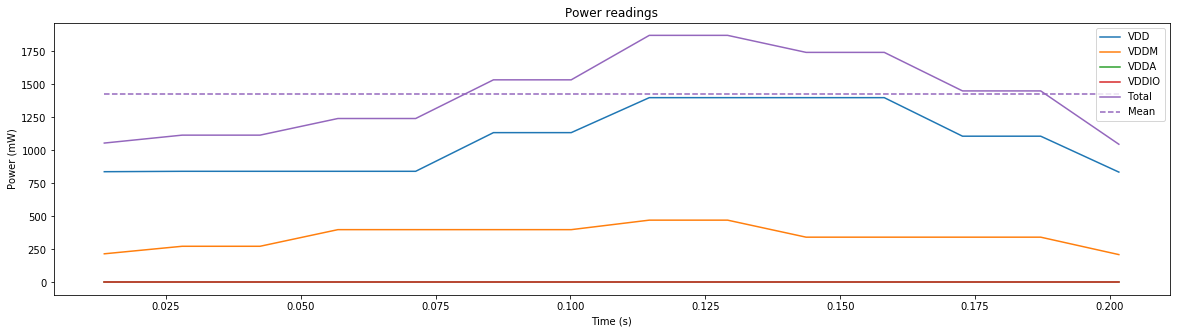

In [17]:
plt.figure(figsize=(20, 5))
eProbe.plotPower()

Even before execution starts, the system consumes a certain level of background power. During execution the power level gradually rises and drops again. This power profile does not actually reflect the true power profile of the system due to transients and latencies in power sensor readout.

Each power components is computed from independent sensor readings for voltage and current. These sensors have transient time constants on the order of 10's of milli seconds. As a result, fast changes in power on milli second time scales or below are not observable and are therefore averaged out. Therefore, the power level gradually increases, remains constant for most of the run and then decreases gradually for some time after execution finishes.

### 5.3 Impact of bufferSize and binSize
The execution time buffer stores the execution times of the various phases within a time step in the memory of the embedded Lakemont CPU at runtime. The binSize determines how many phase durations of the same kind are summed and stored in the same bin of the buffer. The bufferSize controlls the number of bins in the buffer. 

The maximum size of the buffer depends on memory utilization on the Lakemont CPU by user-programs and -data. Here we use a maximum buffer size of at most 1024*3.

To illustrate the impact of bufferSize and binSize, we compare two runs with reduced bufferSize and reduced binSize against a reference run.

In [18]:
# Reference
maxBufferSize = 1024*3
binSize = 8
numRepetitions = 16
runtime = maxBufferSize*binSize*numRepetitions
eProbe0, _, _, _ = runNetwork(
    numCoresPerChip=128, 
    numCompartmentsPerCore=1024, 
    numAxonsPerCompartment=1, 
    numSynPerAxon=1, 
    interSpikeInterval=runtime*2, 
    runtime=runtime,
    bufferSize=maxBufferSize, 
    binSize=binSize
)
# Reduced bufferSize
maxBufferSize = 1024*1
binSize = 8
eProbe1, _, _, _ = runNetwork(
    numCoresPerChip=128, 
    numCompartmentsPerCore=1024, 
    numAxonsPerCompartment=1, 
    numSynPerAxon=1, 
    interSpikeInterval=runtime*2, 
    runtime=runtime,
    bufferSize=maxBufferSize, 
    binSize=binSize
)
# Reduced binSize
maxBufferSize = 1024*3
binSize = 1
eProbe2, _, _, _ = runNetwork(
    numCoresPerChip=128, 
    numCompartmentsPerCore=1024, 
    numAxonsPerCompartment=1, 
    numSynPerAxon=1, 
    interSpikeInterval=runtime*2, 
    runtime=runtime,
    bufferSize=maxBufferSize, 
    binSize=binSize
)

INFO:DRV:  SLURM is being run in background
INFO:HST:  srun: job 2522126 queued and waiting for resources
INFO:HST:  srun: job 2522126 has been allocated resources
INFO:DRV:  Connecting to 134.134.68.92:42407
INFO:DRV:      Host server up..............Done 13.87s
INFO:DRV:      Compiling Embedded snips....Done 0.12s
INFO:DRV:      Encoding axons/synapses.....Done 7.14s
INFO:HST:  Config /etc/nx/pio.cfg
INFO:HST:  Args chip=0 cpu=0 /home/gorchard/nxsdk-nxsdk/nxsdk/driver/compilers/../../../temp/1590103596.770019/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 7.84s
INFO:DRV:      Encoding probes.............Done 0.96ms
INFO:DRV:      Transferring probes.........Done 7.50ms
INFO:DRV:      Configuring registers.......Done 1.98s
INFO:DRV:      Transferring spikes.........Done 0.58ms
INFO:DRV:      Executing...................Done 4.86s
INFO:DRV:      Processing timeseries.......Done 0.52s
INFO:DRV:  Executor:

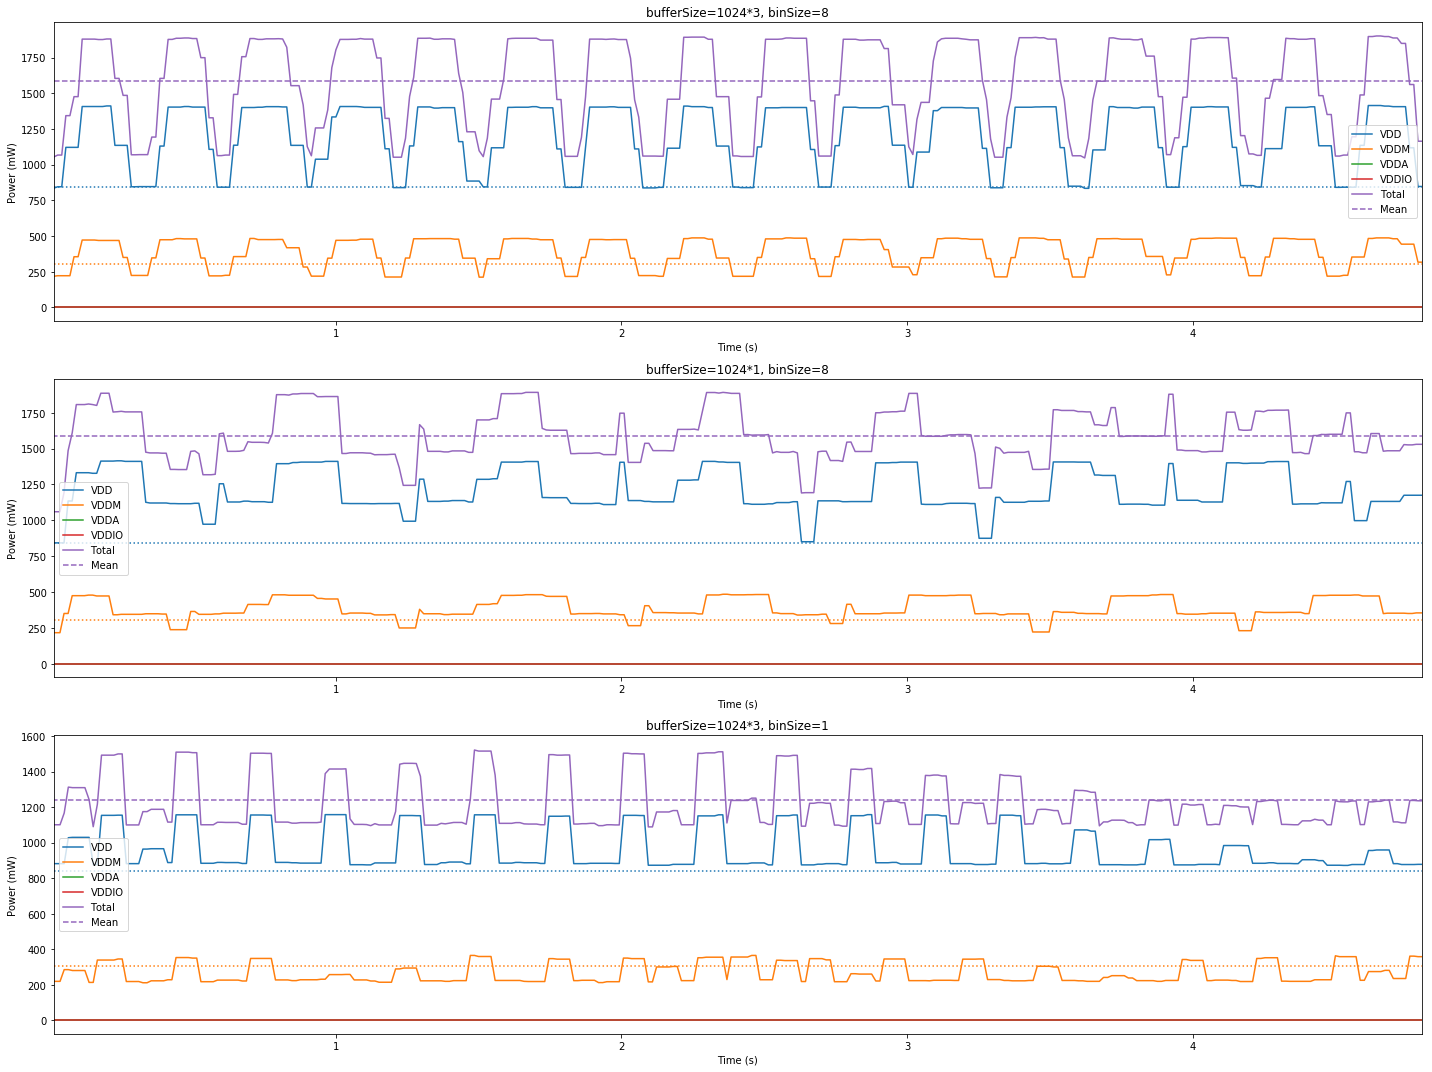

In [19]:
xlim = [eProbe0.time[0], eProbe0.time[-1]]
plt.figure(figsize=(20, 15))
ax = plt.subplot(3, 1, 1)
ls = eProbe0.plotPower()
plt.hlines(avgVddPower, *xlim, linestyle=':', color=ls[0].get_color())
plt.hlines(avgVddmPower, *xlim, linestyle=':', color=ls[1].get_color())
plt.xlim(xlim)
plt.title('bufferSize=1024*3, binSize=8')

plt.subplot(3, 1, 2)
eProbe1.plotPower()
plt.hlines(avgVddPower, *xlim, linestyle=':', color=ls[0].get_color())
plt.hlines(avgVddmPower, *xlim, linestyle=':', color=ls[1].get_color())
plt.xlim(xlim)
plt.title('bufferSize=1024*1, binSize=8')

plt.subplot(3, 1, 3)
eProbe2.plotPower()
plt.hlines(avgVddPower, *xlim, linestyle=':', color=ls[0].get_color())
plt.hlines(avgVddmPower, *xlim, linestyle=':', color=ls[1].get_color())
plt.xlim(xlim)
plt.title('bufferSize=1024*3, binSize=1')
plt.tight_layout()

__[Top panel] Reference:__ 
Due to the long runtime, the execution time buffer needs to be transferred multiple times from Lakemont to host. This leads to alterations of high power active phases during which neuro cores execute and low power idle phases during which neuro cores are idle and the execution time buffer is transferred to the host. Dotted lines show the respective backgrond power levels of VDD and VDDM.

__[Middle panel] Reduced bufferSize (bufferSize=1024*1, binSize=8):__
- Duration of high power active phase is reduced because the execution time buffer on the Lakemont CPU fills up more quickly requiring a transfer to the host.
- Duration of low power idle phase between active phases is also reduced because of the smaller buffer to be transferred.
- As a result of the low power phase having similar duration as the sampling interval of the power sensor, a frequency beating pattern can occur (here in the level of the minimum power level).

__[Bottom panel] Reduced binSize (bufferSize=1024*3, binSize=1):__
- Duration of the high power active phase is reduced because the phase duration of fewer time steps get accumulated in the same bin of the execution time buffer.
- Duration of the lower power idle phase has not changed because the same-sized buffer is transferred from the Lakemont CPU to the host.
- In this case, the high power active phase has similar duration as the sampling interval of the power sensor which results in a frequency beating effect of the high power level.

This shows that when either or both of the bufferSize or binSize is too small a frequency beating effect in the power measurement can occur. Thus both values should be chosen large enough.
Note that, when the workload per time step increases, the duration the time steps also increases.

## 5.4 Setting up a Power Test 
The time constant of the power measurements is significantly longer than a typical Loihi timestep or phase duration, so only the average power for a workload can be measured in this way. Finer grained power measurements of individual workload components requires designing a workload that isolates this component. 

For example, a particular algorithm may require a core to be reset. Power probes can report the average power of the algorithm, but not how much energy was consumed just by the reset itself. To isolate the reset power, we would write a test that just resets the core, without running the other algorithm steps. 

However, a single reset would be too short in duration for the power to be accurately measured, so for power measurement we would repeatedly reset the core and measure the average power. At the scale of a single core, the power consumed by reset would still be very small compared to the overall system power (which in the case of Nahuku32 would include all Nahuku32 chips) and could therefore be lost in the power measurement noise. The solution is to replicate the workload across many cores/chips and divide the result by the total number of copies.

In general, more accurate measurements can be obtained by repeating the workload, both by having multiple copies running simultaneously, and by having each repeat its computation multiple times.

## 5.5 Components of Power Consumption
Power consumption can be broken down into "static" (transistor leakage) and "dynamic" (switching) components. Power consumption can also be broken down by Loihi component: Lakemonts and Neurocores.

Lakemonts are always fully powered, so there is no way to reduce Lakemont static power consumption. However, power probes know how many Lakemonts a model uses and will report the static power for those Lakemonts.

Unlike Lakemonts, unused Neurocores can be partially powered down to reduce their static power consumption, and this is handled automatically by NxSDK. The power probes will also automatically remove any power consumed by unused/partially powered down cores from the detailed power measurement.

Lakemont dynamic power consists of clock power, and additional power consumed by code execution (when a Lakemont is not in a "waiting" state). NxSDK will only clock the Lakemonts which are in use, and will measure the percentage of time each clocked Lakemont is executing code. These measurements are used to determine how much dynamic power Lakemonts are consuming. 
Clock power can be significant, almost 1.5W in total for all 96 Lakemonts on a Nahuku32, and clocked Lakemonts continue to consume clock power, even when not performing any computation (such as when waiting for the next Loihi phase to start).

Neurocore dynamic power depends entirely on computation being performed. If a Neurocore has finished its computation for the current phase and is waiting for the start of the next phase, it will not consume any dynamic power (the Neurocores are asynchronous, there is no clock).

## 5.6 Reported Breakdown of Power
When power probes are used, the shutdown sequence of the board is modified. Additional power measurements are taken after Neurocore computation completes, after the Lakemonts stop, and after the cores are powered down. These additional power measurements are used to compute the breakdown between Neurocore/Lakemont, and static/dynamic components of power consumption.

The power breakdown is therefore only available after disconnecting from the board.

## 5.7 Power Report Format
The different components of power consumption are reported as a dictionary accessible through **board.energyTimeMonitor.powerProfileStats.power** 

All power measurements are in units of mW.

The fields are:
 - **total**: The total power consumption of the system during the run including all used and unused components
 - **idle**: The total power consumption of the system after Neurocore and Lakemont execution has finished, but Lakemonts are still clocked
 - **static**: The total static power consumption of the system during the run
 - **dynamic**: The total dynamic power consumption of the system during the run
 - **core**: A dictionary holding breakdown of the Neurocore power consumption
   - **logic_static**: Total leakage for logic in all used Neurocores
   - **SRAM_static**: Total leakage for memory in all used Neurocores
   - **static**: Total leakage of all used Neurocores
   - **dynamic**: Total dynamic power of all used Neurocores during the run
 - **lakemont**: A dictionary holding breakdown of the Lakemont power consumption
   - **logic_static**: Total leakage for logic in all used Lakemonts
   - **SRAM_static**: Total leakage for memory in all used Lakemonts
   - **static**: Total leakage of all used Lakemonts
   - **clock**: Total clock power for all used Lakemonts
   - **code**: Additional power consumed by code execution across all Lakemonts
   - **dynamic**: Total dynamic power for all used Lakemonts

## 5.8 Power to Energy
Power can be converted to Average Energy Per Timestep by multiplying by the average timestep duration, which is accessible through **board.energyTimeMonitor.powerProfileStats.timePerTimestep**.

The timestep duration is in micro seconds (us), so the resulting energy measurement is in nano Joules (nJ)

## 6. Workload scaling
Here we will illustrate the dependence of workload size on power and execution time using the tools described in Section 5 above.

In order to vary the workload size, we define a helper function to create and run networks with different number of cores per chip and different number of neurons per core. 
For each run, we extract the neurocore dynamic power.

In [20]:
def sweepWorkloadSize(numCoresPerChip, numNeuronsPerCore, 
                      numAxonsPerNeuron=1, numSynPerNeuron=1,
                      interSpikeInterval=1, maxBufferSize=1024*3,
                      binSize=8, numRepetitions=4):
    
    # Turn off status output from NxDriver
    from nxsdk.logutils.nxlogging import set_verbosity, LoggingLevel
    set_verbosity(LoggingLevel.WARNING)
        
    # Sweep number of cores per chip and number of neurons per core
    stats = []
    runtime = maxBufferSize*binSize*numRepetitions
    if interSpikeInterval is None:
        interSpikeInterval = runtime*2
    print('Sweeping numCoresPerChip and numNeuronsPerCore...')
    for i, c in enumerate(numCoresPerChip):
        print('    numCoresPerChip={} in {}'.format(c, numCoresPerChip))
        s = []
        for j, n in enumerate(numNeuronsPerCore):
            print('        numNeuronsPerCore={} in {}'.format(n, numNeuronsPerCore))
            
            eProbe, _, _, powerStats = runNetwork(
                numCoresPerChip=c, 
                numCompartmentsPerCore=n, 
                numAxonsPerCompartment=numAxonsPerNeuron, 
                numSynPerAxon=numSynPerNeuron, 
                interSpikeInterval=interSpikeInterval, 
                runtime=runtime,
                bufferSize=maxBufferSize, 
                binSize=binSize
            )
            
            s.append(powerStats)
        stats.append(s)
    
    return stats

### 6.1 Power, energy and time to solution with spikes enabled

In [21]:
numCoresPerChip=[1, 32, 64, 96, 128]
numNeuronsPerCore=[0, 256, 512, 768, 1024]
powerStats_spikes = sweepWorkloadSize(
    numCoresPerChip, numNeuronsPerCore,
    numAxonsPerNeuron=1, interSpikeInterval=1
)

Sweeping numCoresPerChip and numNeuronsPerCore...
    numCoresPerChip=1 in [1, 32, 64, 96, 128]
        numNeuronsPerCore=0 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=256 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=512 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=768 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=1024 in [0, 256, 512, 768, 1024]
    numCoresPerChip=32 in [1, 32, 64, 96, 128]
        numNeuronsPerCore=0 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=256 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=512 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=768 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=1024 in [0, 256, 512, 768, 1024]
    numCoresPerChip=64 in [1, 32, 64, 96, 128]
        numNeuronsPerCore=0 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=256 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=512 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=768 in [0, 256, 512, 768, 1024]
  

### 6.2 Power, energy and time to solution without spikes

In [22]:
powerStats_noSpikes = sweepWorkloadSize(
    numCoresPerChip, numNeuronsPerCore,
    numAxonsPerNeuron=0, interSpikeInterval=1e9
)

Sweeping numCoresPerChip and numNeuronsPerCore...
    numCoresPerChip=1 in [1, 32, 64, 96, 128]
        numNeuronsPerCore=0 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=256 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=512 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=768 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=1024 in [0, 256, 512, 768, 1024]
    numCoresPerChip=32 in [1, 32, 64, 96, 128]
        numNeuronsPerCore=0 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=256 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=512 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=768 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=1024 in [0, 256, 512, 768, 1024]
    numCoresPerChip=64 in [1, 32, 64, 96, 128]
        numNeuronsPerCore=0 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=256 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=512 in [0, 256, 512, 768, 1024]
        numNeuronsPerCore=768 in [0, 256, 512, 768, 1024]
  

### 6.3 Comparison of power, energy and time to solution

In [23]:
def plotData(numCoresPerChip, numNeuronPerCore, power, title, ylabel):
    """Plots data per run as a function of number of cores per chip."""
    
    ls = plt.plot(numCoresPerChip, power, marker='.', markersize=12, linestyle='--')
    plt.title(title)
    plt.legend(ls, numNeuronsPerCore)
    plt.xlabel('numCoresPerChip')
    plt.ylabel(ylabel)

In [24]:
power_spikes = np.array([[stats.power['core']['dynamic'] for stats in statslist] for statslist in powerStats_spikes])
power_noSpikes = np.array([[stats.power['core']['dynamic'] for stats in statslist] for statslist in powerStats_noSpikes])
time_spikes = np.array([[stats.timePerTimestep for stats in statslist] for statslist in powerStats_spikes])
time_noSpikes = np.array([[stats.timePerTimestep for stats in statslist] for statslist in powerStats_noSpikes])

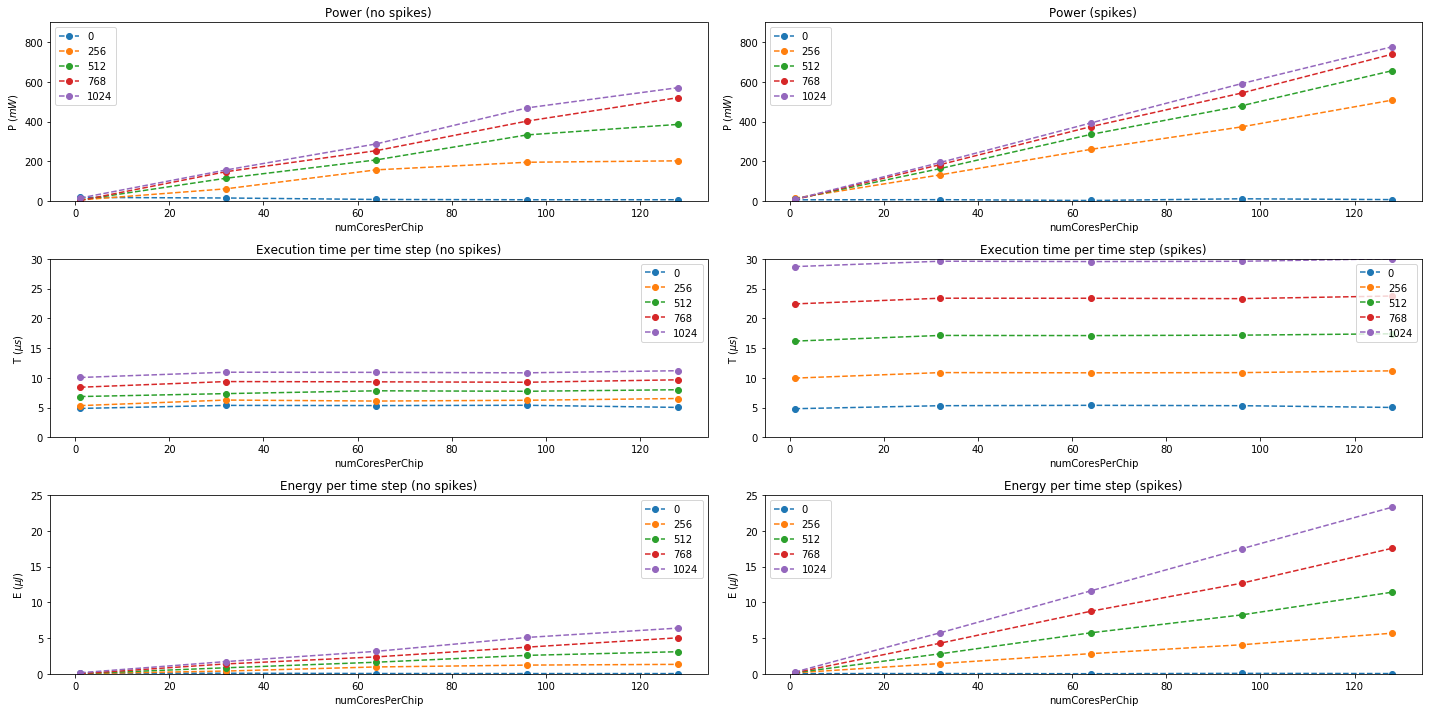

In [25]:
plt.figure(figsize=(20,10))

energy_noSpikes = power_noSpikes*time_noSpikes
energy_spikes = power_spikes*time_spikes

plt.subplot(3, 2, 1)
plotData(numCoresPerChip, numNeuronsPerCore, power_noSpikes, 'Power (no spikes)', 'P ($mW$)')
plt.ylim(0, 900)
plt.subplot(3, 2, 2)
plotData(numCoresPerChip, numNeuronsPerCore, power_spikes, 'Power (spikes)', 'P ($mW$)')
plt.ylim(0, 900)
plt.subplot(3, 2, 3)
plotData(numCoresPerChip, numNeuronsPerCore, time_noSpikes, 'Execution time per time step (no spikes)', 'T ($\mu s$)')
plt.ylim(0, 30)
plt.subplot(3, 2, 4)
plotData(numCoresPerChip, numNeuronsPerCore, time_spikes, 'Execution time per time step (spikes)', 'T ($\mu s$)')
plt.ylim(0, 30)
plt.subplot(3, 2, 5)
plotData(numCoresPerChip, numNeuronsPerCore, energy_noSpikes/1e3, 'Energy per time step (no spikes)', 'E ($\mu J$)')
plt.ylim(0, 25)
plt.subplot(3, 2, 6)
plotData(numCoresPerChip, numNeuronsPerCore, energy_spikes/1e3, 'Energy per time step (spikes)', 'E ($\mu J$)')
plt.ylim(0, 25)

plt.tight_layout()

__Observations__:
- Power depends on number of active cores
- Execution time depends on number of neurons per core and spike traffic